# Imports and loading data

In [1]:
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import statistics
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    roc_auc_score,
    average_precision_score,
)

import vrme_lib

df_embeddings, df_submissions, df_submission_labels, df_embeddings_2017, df_embeddings_2018 = vrme_lib.load_data()

# Naive Difference in Means Estimator



In [7]:
bootstrap_naive_mean = []

for n in range(5000):
    sample_2017 = df_embeddings_2017.AVG_rating.sample(n=df_embeddings_2017.shape[0], replace = True ,random_state=n)
    sample_2018 = df_embeddings_2018.AVG_rating.sample(n=df_embeddings_2018.shape[0], replace = True ,random_state=n)
    
    sample_diff = sample_2018.mean() - sample_2017.mean()
    
    bootstrap_naive_mean.append(sample_diff)
    
vrme_lib.print_results(name="Naive",
                        atc = df_embeddings_2018.AVG_rating.mean() - df_embeddings_2017.AVG_rating.mean(),
                      ci_lower_bound=np.quantile(bootstrap_naive_mean, 0.025),
                      ci_upper_bound=np.quantile(bootstrap_naive_mean, 0.975))

Naive ATC: -0.2517
Naive CI: [-0.3949, -0.1135]
Naive CI range: 0.2814


# Stratified Propensity Score Matching

In [9]:
def get_strata(prob_t_score, num_strata): 
    """
    Reports the strata given the probability score 
    
    Strata index starts at 1 
    """
    strata = np.arange(0, 1.0, 1.0/num_strata)
    return np.digitize(prob_t_score, strata, right=False)

df_embeddings = df_embeddings.merge(df_submission_labels[df_submission_labels['conf_year'].isin([2017,2018])], left_on='paper_id',right_on='id')
df_embeddings['treatment'] = df_embeddings['conf_year'].replace([2017,2018],[1,0])

E = np.array([np.array(embedding) for embedding in df_embeddings.embedding.to_list()])
T = np.array(df_embeddings.treatment.to_list())
paper_id = np.array(df_embeddings.id.to_list())

assert E.shape[0] == T.shape[0] == df_embeddings.shape[0] == paper_id.shape[0]

n_total = df_embeddings.shape[0]
docids = paper_id

assert n_total == docids.shape[0] == T.shape[0]
    
    
NUM_CROSSFIT_SPLITS = 2
NUM_CROSSVAL_SPLITS = 4 
RANDOM_STATE = 42 #for replication 

CLASSIFIER = Pipeline([(
            "model",
            LogisticRegression(
                l1_ratio=0.1,
                solver="saga",
                max_iter=20000,
                tol=1e-3, 
                penalty="elasticnet",
                dual=False,
                class_weight="balanced",
                random_state=42,
                ),),])

CLASSIFIER_GRID = {
    "model__C": [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1],
}

#Note: May take awhile to run
prob_t_training = np.array([np.nan]*n_total) #only for reporting training acc numbers 
prob_t_inference = np.array([np.nan]*n_total) #array to save predicted propensity scores 
# Crossfitting 


crossfit_split = list(StratifiedKFold(n_splits=NUM_CROSSFIT_SPLITS, shuffle=True, random_state=RANDOM_STATE).split(E, T))
for crossfit_number, (train_inds, test_inds) in enumerate(crossfit_split):
    inner_cv = StratifiedShuffleSplit(
                n_splits=NUM_CROSSVAL_SPLITS,
                test_size=1/NUM_CROSSVAL_SPLITS,
                random_state= RANDOM_STATE,
            )
    
    t_model_gridsearch = GridSearchCV(
                        estimator=deepcopy(CLASSIFIER),
                        param_grid=deepcopy(CLASSIFIER_GRID),
                        cv=inner_cv,
                        scoring="roc_auc",
                        refit=True,
                    )
    
    t_model_gridsearch.fit(E[train_inds], T[train_inds])
    prob_t_training[train_inds] = t_model_gridsearch.predict_proba(E[train_inds])[:, 1]
        
    # Inference
    # Probability of T=1
    prop_t = t_model_gridsearch.predict_proba(E[test_inds])[:, 1]
    prob_t_inference[test_inds] = prop_t

assert np.mean(np.isnan(prob_t_training)) == 0.0
assert np.mean(np.isnan(prob_t_inference)) == 0.0

# Training metrics 
pred_model_report_out = {}

# these classification metrics need the "hard" predictions, e.g. y=[0, 0, 1, ...]
class_hard_name2metric_func = {
    "f1": f1_score,
    "acc": accuracy_score,
    "mean_hard_pred": vrme_lib.mean_predictions,
    "mean_true": vrme_lib.mean_truth,  # should be same for hard or soft
}

# these classification metrics need the "score" predictions, e.g. y=[0.6, 0.77, 0.2, ...]
class_scores_name2metric_func = {
    "roc_auc": roc_auc_score,
    "ave_prec": average_precision_score,
    "calibration_rmse": vrme_lib.calibration_rmse,
    "mean_soft_pred": vrme_lib.mean_predictions,
    "mean_true": vrme_lib.mean_truth,  # should be same for hard or soft
}

#hard classifications
t_pred_hard = (prob_t_training > 0.5).astype(int)

assert t_pred_hard.shape == prob_t_training.shape == T.shape

NUM_STRATA = 5   
docid2strata = {}
for docid, prob_t_score in zip(docids, prob_t_inference): 
    strata_inferred = get_strata(prob_t_score, NUM_STRATA)
    docid2strata[docid] = (strata_inferred, prob_t_score)
data = []
for x in docid2strata.items():
    input_row = {}
    input_row['paperID'] = x[0]
    input_row['strata'] = x[1][0]
    input_row['pscore'] = x[1][1]
    data.append(input_row)


df_paper_strata = df_embeddings.merge(pd.DataFrame(data), left_on='paper_id',right_on='paperID')[['paper_id','title','strata','keywords','pscore','treatment','AVG_rating','conf_year']]
df_paper_strata['transformed_keywords'] = df_paper_strata.apply(lambda x: vrme_lib.strip_char(x), axis = 1)


boostrap_SPSM = []
for n in range(5001):
    sample = df_paper_strata[df_paper_strata['treatment'] ==1].sample(n=490, replace = True ,random_state=n)

    strata_2_weight = sample[(sample['strata'] ==2) & (sample['treatment'] ==1)].shape[0]/490

    strata_3_weight = sample[(sample['strata'] ==3) & (sample['treatment'] ==1)].shape[0]/490

    strata_4_weight = sample[(sample['strata'] ==4) & (sample['treatment'] ==1)].shape[0]/490

    strat_2_treated = sample[(sample['strata'] ==2) & (sample['treatment'] ==1)]['AVG_rating'].mean()
    strat_2_control = df_paper_strata[(df_paper_strata['strata'] ==2) & (df_paper_strata['treatment'] ==0)]['AVG_rating'].mean()
    
    strat_3_treated = sample[(sample['strata'] ==3) & (sample['treatment'] ==1)]['AVG_rating'].mean()
    strat_3_control = df_paper_strata[(df_paper_strata['strata'] ==3) & (df_paper_strata['treatment'] ==0)]['AVG_rating'].mean()
    
    strat_4_treated = sample[(sample['strata'] ==4) & (sample['treatment'] ==1)]['AVG_rating'].mean()
    strat_4_control = df_paper_strata[(df_paper_strata['strata'] ==4) & (df_paper_strata['treatment'] ==0)]['AVG_rating'].mean()

    ATT = (strat_4_treated - strat_4_control)* strata_4_weight + (strat_3_treated - strat_3_control)* strata_3_weight + (strat_2_treated - strat_2_control)* strata_2_weight
    boostrap_SPSM.append(ATT)

#ATC SPSM
strata_2_weight = df_paper_strata[(df_paper_strata['strata'] ==2) & (df_paper_strata['treatment'] ==1)].shape[0]/490
strata_3_weight = df_paper_strata[(df_paper_strata['strata'] ==3) & (df_paper_strata['treatment'] ==1)].shape[0]/490
strata_4_weight = df_paper_strata[(df_paper_strata['strata'] ==4) & (df_paper_strata['treatment'] ==1)].shape[0]/490
strat_2_treated = df_paper_strata[(df_paper_strata['strata'] ==2) & (df_paper_strata['treatment'] ==1)]['AVG_rating'].mean()
strat_2_control = df_paper_strata[(df_paper_strata['strata'] ==2) & (df_paper_strata['treatment'] ==0)]['AVG_rating'].mean()
strat_3_treated = df_paper_strata[(df_paper_strata['strata'] ==3) & (df_paper_strata['treatment'] ==1)]['AVG_rating'].mean()
strat_3_control = df_paper_strata[(df_paper_strata['strata'] ==3) & (df_paper_strata['treatment'] ==0)]['AVG_rating'].mean()
strat_4_treated = df_paper_strata[(df_paper_strata['strata'] ==4) & (df_paper_strata['treatment'] ==1)]['AVG_rating'].mean()
strat_4_control = df_paper_strata[(df_paper_strata['strata'] ==4) & (df_paper_strata['treatment'] ==0)]['AVG_rating'].mean()

SPSM_mean = (strat_4_treated - strat_4_control)* strata_4_weight + (strat_3_treated - strat_3_control)* strata_3_weight + (strat_2_treated - strat_2_control)* strata_2_weight


vrme_lib.print_results(name="SPSM",
                      atc=round(-SPSM_mean,2),
                      ci_lower_bound=round(np.nanquantile(boostrap_SPSM, 0.025),2),
                      ci_upper_bound=round(np.nanquantile(boostrap_SPSM, 0.975),2))


SPSM ATC: -0.26
SPSM CI: [0.14, 0.38]
SPSM CI range: -0.24


# Propensity score distribution

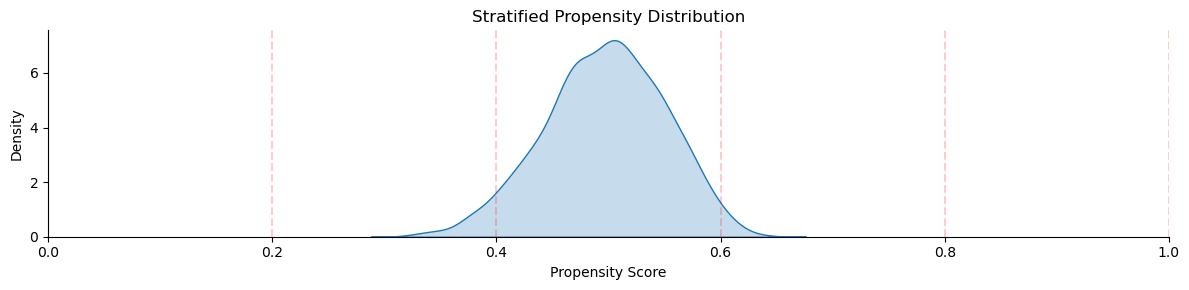

In [4]:
sns.displot(df_paper_strata,x='pscore',kind='kde',fill=True, height=3, aspect=4)
plt.xlim(0,1)
plt.axvline(0., alpha=0.2,color='r')
for x in np.arange(0, 1.2, 0.2):
  plt.axvline(x, alpha=0.2,color='r', linestyle = 'dashed')
plt.xlabel('Propensity Score')
plt.title('Stratified Propensity Distribution')
plt.tight_layout()
plt.savefig('propensity_scores_SPSM.png')

# Preparation for significance calculation

In [5]:
with open('significance_data_spsm.pkl', 'wb') as f:
  pickle.dump({
    "df_paper_strata": df_paper_strata,
  }, f)
  